In [3]:
# @title Завантаження пакетів { vertical-output: true }
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
from ipywidgets import interact
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100


# Апроксимація результатів вимірювання

Часто, результатом фізичного експерименту є виміряні значення пар величин $(x_i, y_i)$. Прийнято величини $y_i$ вважати залежними від величин $x_i$.

In [4]:
# @title Експериментальні дані { vertical-output: true }
from io import StringIO

table = """
x  y
4  8
7  6
9  8
10 13
14 12
17 17
20 20
25 20
"""

data = pd.read_csv(StringIO(table), delimiter='\s+')
df = pd.DataFrame(data, columns=['x', 'y'])
df


,x,y
0,4,8
1,7,6
2,9,8
3,10,13
4,14,12
5,17,17
6,20,20
7,25,20


## Метод найменших квадратів

Зазвичай, на практиці з якихось апріорних чи теоретичних міркувань відомо, який аналітичний вигляд має функція $y = f (x| p_1, p_2, \ldots, p_p)$, що описує експериментальні дані, а невідомими є $p$ штук числових величин $p_i$ $(i = 1 \ldots p)$. Така аналітична функція називається *моделлю*, а величини $p_i$ називаються *параметрами* моделі.

Виникає задача, як підібрати значення параметрів так, щоб графік функції проходив якомога ближче до експериментальних точок? Така процедура називається апроксимацією.

---

(В англомовній літературі ця процедура називається "fitting", що дослівно перекладається як "підгонка" параметрів моделі).

---


Нехай у нас є експериментальні дані $(x_i, y_i)$, ми намагаємось застосувати модель  $y = f(x)$.

Позначимо відстань від $i$-ї експериментальної точки до шуканої прямої, що виміряна по вертикалі як $\Delta y_i$ (цей доданок називається *лишком*):
\begin{equation}
	\Delta y_i = y_i - f(x_i| p_1, p_2, \ldots, p_p)
\end{equation}
і знайдемо суму
\begin{equation}
	\chi^2(p_1, p_2, \ldots, p_p) = \sum\limits_{i = 1}^n  \left(\frac{y_i - f(x_i| p_1, p_2, \ldots, p_p)}{\sigma_{y_i}}\right)^2
\end{equation}
яка залежить від параметрів $p_1, p_2, \ldots, p_p$. Параметри підбираються так, щоб $\chi^2(p_1, p_2, \ldots, p_p) \to \min$. Така сума називається зваженою сумою квадратичних лишків.

Даний метод побудови найкращої прямої називається методом найменших квадратів.

У випадку, якщо більша частина відхилень даних від моделі буде порядку середньоквадратичної похибки, тобто $\Delta y_i \approx \sigma_{y_i}$, то сума $\chi^2$ буде за порядком величини дорівнювати числу доданків, що входять в неї, тобто $\chi^2 \approx n$.

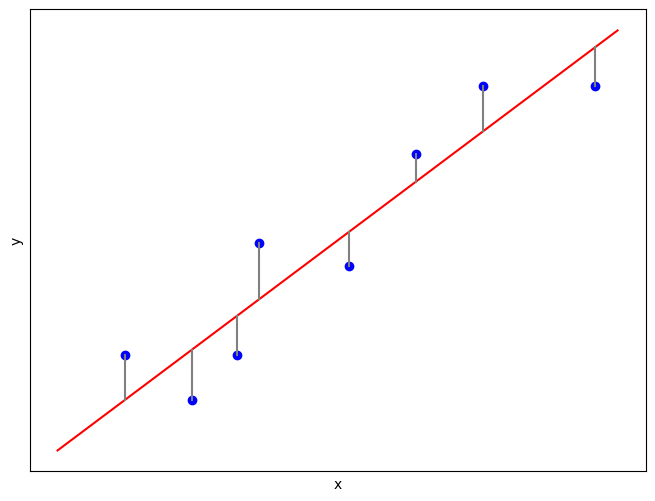

In [5]:
# @title Ілюстрація методу
plt.gca().set_aspect('equal')
plt.xticks([]), plt.yticks([])
plt.xlabel('x'), plt.ylabel('y')


def line(x, a=0.75, c=3):
    return a*x + c


plt.scatter(df['x'], df['y'], color='b')
# plt.errorbar(d['x'], d['y'], d['sy'],
#                 fmt='o', ecolor = 'r', color = 'k',
#                 markersize=5, capsize=4, label="дані")
x = np.linspace(1, 26)
plt.plot(x, line(x), color='r')
plt.plot([df['x'], df['x']], [df['y'], line(df['x'])], color='gray')
print()


## Реальний приклад: рух каменя

Камінь кинули вгору. Зняли вимірювання залежності висоти каменя над поверхнею землі від часу [$t$ (с), $y$ (м), $\Delta y$ (м)]

In [6]:
# @title Експериментальні дані { vertical-output: true }
table = """
time pos spos
0.0 0.16 0.42
0.1 3.12 0.53
0.2 2.82 0.55
0.3 3.70 0.48
0.4 4.39 0.45
0.5 5.90 0.51
0.6 5.45 0.48
0.7 7.27 0.48
0.8 6.39 0.44
0.9 6.91 0.50
1.0 7.03 0.52
1.1 8.13 0.49
1.2 8.00 0.51
1.3 7.56 0.52
1.4 8.45 0.57
1.5 7.95 0.50
1.6 7.97 0.43
1.7 6.89 0.50
1.8 7.19 0.54
1.9 6.49 0.46
2.0 4.98 0.53
"""

d = pd.read_csv(StringIO(table), delimiter='\s+')
d


,time,pos,spos
0,0.0,0.16,0.42
1,0.1,3.12,0.53
2,0.2,2.82,0.55
3,0.3,3.70,0.48
4,0.4,4.39,0.45
5,0.5,5.90,0.51
6,0.6,5.45,0.48
7,0.7,7.27,0.48
8,0.8,6.39,0.44
9,0.9,6.91,0.50


Будуємо експериментальні точки з вказанням похибок $\Delta y$ у виміряних значеннях висоти підняття каменя $y$.

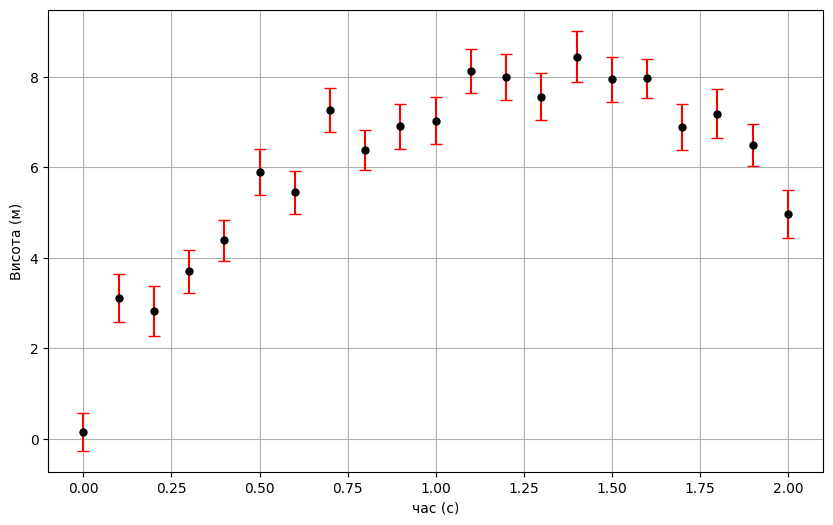

In [7]:
# @title Графік залежності висоти $y(t)$
plt.errorbar(d['time'], d['pos'], d['spos'],
             fmt='o', ecolor='r', color='k',
             markersize=5, capsize=4)
plt.grid(True)
plt.ylabel("Висота (м)")
plt.xlabel("час (с)")
plt.savefig("dataonly.pdf")


Спробуйте самостійно підібрати параметри $y_0$, $v_0$ та $a$ моделі $y = y_0 + v_0 t + \frac{at^2}{2}$ рухаючи повзунки.  Спостерігайте за значенням $\chi^2$. Модель буде найкраще описувати дані, якщо $\chi^2$ буде наближено дорівнювати числу експериметальних точок ($n = 21$ в нашому випадку, тобто $\chi^2 \approx 21$).

In [19]:
# @title Ручний підбір параметрів

def HandChoise(y0, v0, a):

    def model(t, y0, v0, a):
        return y0 + v0*t + 0.5*a*t**2

    plt.errorbar(d['time'], d['pos'], d['spos'],
                 fmt='o', ecolor='r', color='k',
                 markersize=5, capsize=4, label="дані")
    plt.ylabel("Висота (м)")
    plt.xlabel("час (с)")
    plt.grid(True)

    t = np.linspace(0, 2)
    plt.plot(t, model(t, y0, v0, a), color='b', label="модель")
    plt.legend(bbox_to_anchor=(0.01, 0.99), loc='upper left', borderaxespad=0.)

    chisq = sum((d['pos'] - model(d['time'], y0, v0, a))**2/d['spos']**2)

    plt.title("$\\chi^2 = %.2f$" % chisq)


interact(HandChoise, y0=(-2.0, 5.0), v0=(0.0, 20.0), a=(-15.0, -3.0))


interactive(children=(FloatSlider(value=1.5, description='y0', max=5.0, min=-2.0), FloatSlider(value=10.0, des…

<function __main__.HandChoise(y0, v0, a)>

Метод найменших квадратів в якому враховуються лише похибки залежних змінних $y_i$ реалізується за допомогою алгоритму [Левенберга-Марквардта](https://en.wikipedia.org/wiki/Levenberg–Marquardt_algorithm).

Довіримо тепер знаходження парамерів моделі саме цьому алгоритму.

In [9]:
# @title Алгоритм підбору параметрів
# Модельна функція

def model(t, y0, v0, a):
    y = y0 + v0 * t + a * t ** 2 / 2
    return y


# Наближені значення фітингових параметрів
init_guess = [1, 1, -10]

# Апроксимація даних
fit = curve_fit(model, d['time'], d['pos'], sigma=d['spos'],
                p0=init_guess, absolute_sigma=True)

# Запис параметрів у змінні
ans, cov = fit
y0, v0, a = ans
sy0, sv0, sa = np.sqrt(np.diag(cov))


chisq = 22.88
y_0 = (0.75 +/- 0.28) м
v_0 = (11.29 +/- 0.67) м/с
a = (-8.81 +/- 0.65) м/с^2


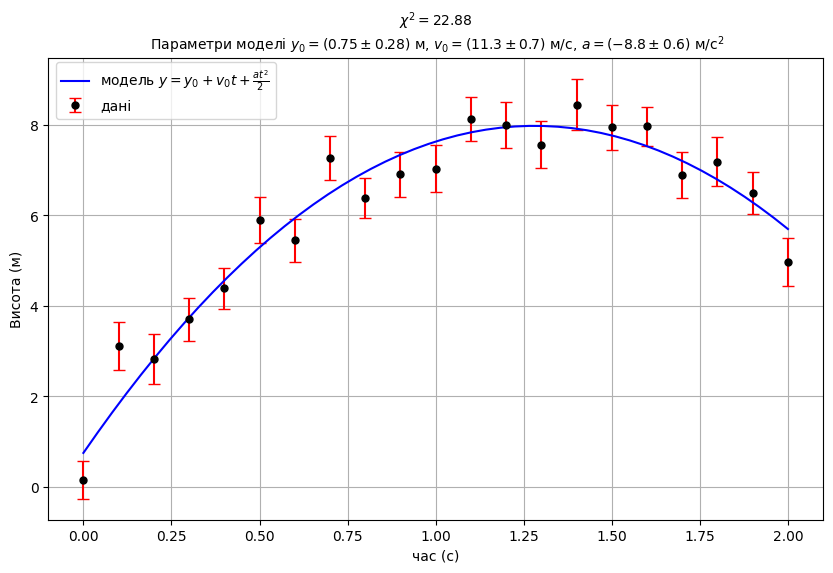

In [10]:
# @title Побудова модельного графіку
# Побудова даних
plt.grid(True)
plt.errorbar(d['time'], d['pos'], d['spos'],
             label="дані", fmt='o', ecolor='r', color='k',
             markersize=5, capsize=4)
plt.ylabel("Висота (м)")
plt.xlabel("час (с)")

# Розрахунок хі-квадрату
chisq = sum((d['pos'] - model(d['time'], y0, v0, a))**2/d['spos']**2)

# Побудова графіка за результатами апроксимації
t = np.linspace(0, 2)
plt.plot(t, model(t, y0, v0, a),
         color='b', label="модель $y = y_0 + v_0 t + \\frac{at^2}{2}$")
plt.legend(bbox_to_anchor=(0.01, 0.99), loc='upper left', borderaxespad=0.)

# Виведення результатів на координатну площину
plt.title('$\\chi^2 = %.2f$\n Параметри моделі $y_0 = (%.2f \\pm %.2f)$ м, '
          '$v_0 = (%.1f \\pm %.1f)$ м/с, '
          '$a = (%.1f \\pm %.1f)$ м/с$^2$'
          % (chisq, y0, sy0, v0, sv0, a, sa),
          fontsize=10,
          )

print("chisq = %.2f" % chisq)
print("y_0 = (%.2f +/- %.2f) м" % (y0, sy0))
print("v_0 = (%.2f +/- %.2f) м/с" % (v0, sv0))
print("a = (%.2f +/- %.2f) м/с^2" % (a, sa))


## Метод найменших повних квадратів

У розглянутому вище методі враховуються лише похибки у залежних величинах $y_i$, а тому виникає обмеження в його використанні лише для випадку коли похибками незалежних змінних можна знехтувати ($\sigma_{x_i} \approx 0$).  Однак, на практиці виникає потреба у такому методі, в якому цими похибками нехтувати не можна. Тому треба будувати суму $\chi^2$ з урахуванням похибок $\sigma_{x_i}$. Ідея такої побудови полягає в тому, щоб в якості
доданків брати не відстань від точки до прямої по вертикалі $d_{\parallel_i} = |y_i - f(x_i)|$, а ортогональну відстань від точки до прямої $d^2_{\perp_i} = (x_i - \tilde{x}_i)^2  + (y_i - \tilde{y}_i)^2$, причому, кожен із доданків в сумі треба взяти з відповідним ваговим коефіцієнтом, що обернений до похибки. Тоді сума для мінімізації прийме вигляд:
\begin{equation}
	\tilde{\chi}^2 = \sum\limits_{i = 1}^n  \left[\left(\frac{x_i - \tilde{x}_i}{\sigma_{x_i}}\right)^2 + \left(\frac{y_i - f(\tilde{x}_i)}{\sigma_{y_i}}\right)^2\right],
\end{equation}
де точка $(\tilde{x}_i,\tilde{y}_i)$ розташована на шуканій прямій на найкоротшій (ортогональній) відстані від експериментальної точки $(x_i, y_i)$.



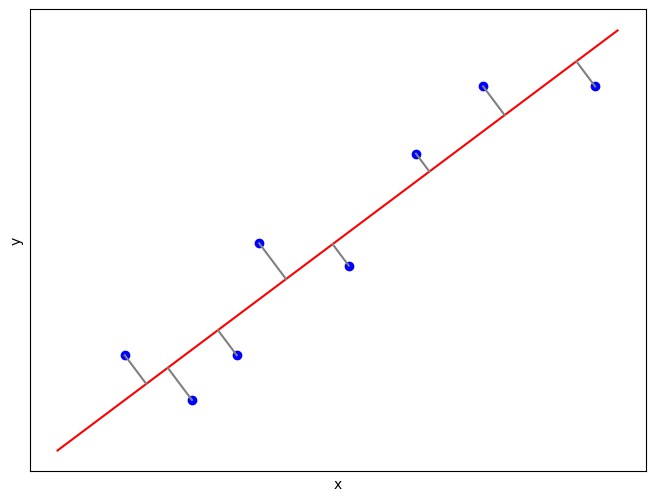

In [11]:
# @title Ілюстрація методу
plt.gca().set_aspect('equal')
plt.xticks([]), plt.yticks([])
plt.xlabel('x'), plt.ylabel('y')


def line(x, a=0.75, c=3):
    return a*x + c


def xp(x, y, a=0.75, b=-1, c=3):
    return (b*(b*x - a*y) - a*c)/(a ** 2 + b ** 2)


def yp(x, y):
    return line(xp(x, y))


plt.scatter(df['x'], df['y'], color='b')
x = np.linspace(1, 26)
plt.plot(x, line(x), color='r')
xd = xp(df['x'], df['y'])
yd = yp(df['x'], df['y'])
plt.plot([df['x'], xd], [df['y'], line(xd)], color='gray')
print()


## Реальний приклад: рух каменя

Розглянемо тепер ті ж самі експериментальні дані, але врахуємо похибку годинника. Тепер наші дані виглядатимуть як [$t$ (с), $y$ (м), $\Delta t$ (с),$\Delta y$ (м)]

In [12]:
# @title Експериментальні дані { vertical-output: true }
data_array = np.array([
    [0.00, 0.16, 0.03, 0.42],
    [0.10, 3.12, 0.03, 0.53],
    [0.20, 2.82, 0.03, 0.55],
    [0.30, 3.70, 0.03, 0.48],
    [0.40, 4.39, 0.03, 0.45],
    [0.50, 5.90, 0.03, 0.51],
    [0.60, 5.45, 0.03, 0.48],
    [0.70, 7.27, 0.03, 0.48],
    [0.80, 6.39, 0.03, 0.44],
    [0.90, 6.91, 0.03, 0.50],
    [1.00, 7.03, 0.03, 0.52],
    [1.10, 8.13, 0.03, 0.49],
    [1.20, 8.00, 0.03, 0.51],
    [1.30, 7.56, 0.03, 0.52],
    [1.40, 8.45, 0.03, 0.57],
    [1.50, 7.95, 0.03, 0.50],
    [1.60, 7.97, 0.03, 0.43],
    [1.70, 6.89, 0.03, 0.50],
    [1.80, 7.19, 0.03, 0.54],
    [1.90, 6.49, 0.03, 0.46],
    [2.00, 4.98, 0.03, 0.53],
])
d = pd.DataFrame(data_array, columns=['time', 'pos', 'stime', 'spos'])
d


,time,pos,stime,spos
0,0.0,0.16,0.03,0.42
1,0.1,3.12,0.03,0.53
2,0.2,2.82,0.03,0.55
3,0.3,3.70,0.03,0.48
4,0.4,4.39,0.03,0.45
5,0.5,5.90,0.03,0.51
6,0.6,5.45,0.03,0.48
7,0.7,7.27,0.03,0.48
8,0.8,6.39,0.03,0.44
9,0.9,6.91,0.03,0.50


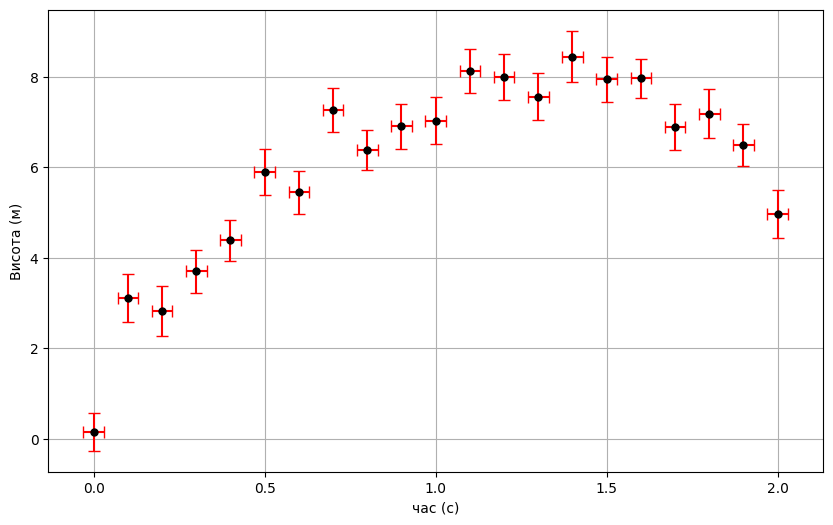

In [13]:
# @title Графік залежності висоти $y(t)$
plt.errorbar(d['time'], d['pos'], xerr=d['stime'], yerr=d['spos'],
             fmt='o', ecolor='r', color='k',  markersize=5, capsize=4)
plt.grid(True)
plt.ylabel("Висота (м)")
plt.xlabel("час (с)")
plt.savefig("dataonly.pdf")


Метод найменших повних квадратів, який враховує похибки як в залежних змінних $y_i$ так і в незалежних змінних $x_i$  реалізується за допомогою алгоритму який називається [Ortohonal Distance Regression](https://en.wikipedia.org/wiki/Total_least_squares). Останній алгоритм важливий для даних, що отримуються в фізичних експериментах. Сам алгоритм був вперше реалізований на мові ```FORTRAN``` під назвою [```ODRPACK```](https://dl.acm.org/doi/10.1145/1268776.1268782), а згодом розповсюджений  в багатьох програмних пакетах по обробці даних.

In [14]:
# @title Викликаємо пакет методу найменших повних квадратів (ODR)
from scipy.odr import ODR, Model, RealData


Задаємо модельну функцію $y = y_0 + v_0 t + \frac{at^2}{2}$

In [15]:
# @title
# Задаємо модельну функцію
def model_func(beta, t):
    """
    Визначення математичної моделі для підгони.

    Параметр підгонки beta[0] та beta[1]
    """
    y = beta[0] + beta[1] * t + beta[2] * t ** 2 / 2
    return y


Задаємо наближені значення параметрів моделі

In [16]:
# @title
init_guess = [1, 1, -10]


Заганяємо дані і модель в алгоритм ODR

In [17]:
# @title
# Здійснюємо підгону даних за моделлю
# https://docs.scipy.org/doc/scipy/reference/odr.html

# Створюємо екземпляр моделі
model = Model(model_func)

# Створюємо екземпляр даних data
data = RealData(d['time'], d['pos'], d['stime'], d['spos'])

# Створюємо ODR зі своїми даними, моделлю та початковою оцінкою параметрів
odr = ODR(data, model, init_guess)

# Вибір методу підгонки
odr.set_job(fit_type=0)
output = odr.run()


Будуємо експериментальні дані та маодельну криву і виводимо параметри моделі

chisq = 19.49
a = (-8.82 +/- 0.74) м/с^2
v_0 = (11.29 +/- 0.77) м/с
y_0 = (0.76 +/- 0.35) м


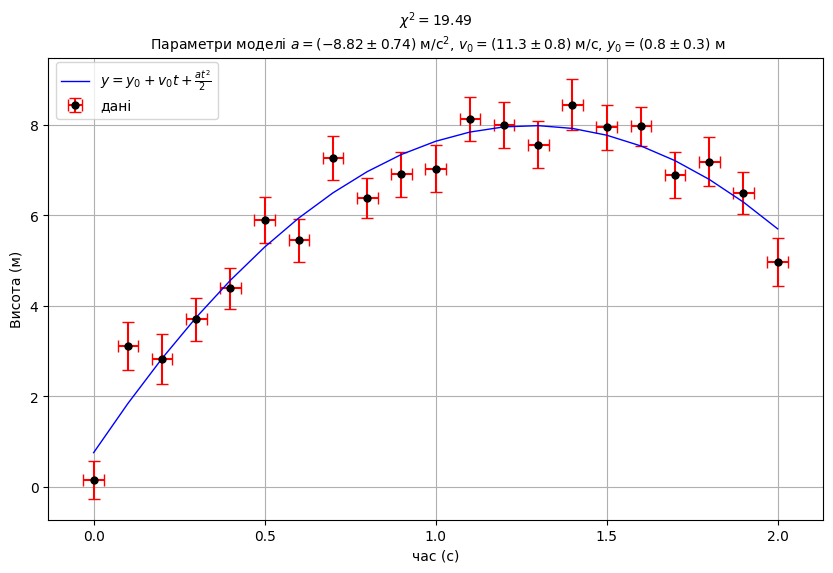

In [18]:
# @title
# Побудова даних
plt.grid(True)
plt.errorbar(d['time'], d['pos'], xerr=d['stime'], yerr=d['spos'],
             fmt='o', ecolor='r', color='k',  markersize=5,
             capsize=4, label="дані")
plt.ylabel("Висота (м)")
plt.xlabel("час (с)")

plt.plot(d['time'], model_func(output.beta, d['time']),
         color="b", linewidth=1, label="$y = y_0 + v_0 t + \\frac{at^2}{2}$")
plt.legend(bbox_to_anchor=(0.01, 0.99), loc='upper left', borderaxespad=0.)

# Виведення результатів на координатну площину
plt.title('$\\chi^2 = %.2f$\n Параметри моделі $a = (%.2f \\pm %.2f)$ м/с$^2$, '
          '$v_0 = (%.1f \\pm %.1f)$ м/с, '
          '$y_0 = (%.1f \\pm %.1f)$ м'
          % (output.res_var*(21-3),
             output.beta[2], output.sd_beta[2],
             output.beta[1], output.sd_beta[1],
             output.beta[0], output.sd_beta[0]),
          fontsize=10,
          )

print("chisq = %.2f" % (output.res_var*(21-3)))
print("a = (%.2f +/- %.2f) м/с^2" % (output.beta[2], output.sd_beta[2]))
print("v_0 = (%.2f +/- %.2f) м/с" % (output.beta[1], output.sd_beta[1]))
print("y_0 = (%.2f +/- %.2f) м" % (output.beta[0], output.sd_beta[0]))


## Як провести успішну апроксимацію?

Для того, щоб скористатись алгоритмами і провести успішну апроксимацію даних, треба дотримуватись наступних правил:


1. Виберіть відповідну модель та визначте число можливих параметрів.
2.   Якщо модель можна лінеаризувати, то краще зробити це.
3. Вкажіть початкові прийнятні значення параметрів моделі.
4. Якщо в результаті апроксимації один з параметрів оцінено з похибкою $\sigma_{p_i} \gg p_i$, що значно перевищує значення самого параметра, то треба покласти знач
